In [241]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [242]:
from ldms_analyzer.ldms_analyzer import LDMSAnalyzer
from ldms_analyzer.util.files import get_files

import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

In [243]:
directory_path = "/pscratch/sd/o/ocankur/data/resource_usage_paper"
patterns = ["*"]
metrics = ["gpu_utilization"]

In [244]:
ldms_files, sacct_files = get_files(directory_path, patterns, metrics)
print(ldms_files)
print(sorted(sacct_files))

['/pscratch/sd/o/ocankur/data/resource_usage_paper/dcgm.gpu_utilization.1694588400.1694847599.9.13_ldms.pq', '/pscratch/sd/o/ocankur/data/resource_usage_paper/dcgm.gpu_utilization.1699344000.1699603199.11.7_ldms.pq', '/pscratch/sd/o/ocankur/data/resource_usage_paper/dcgm.gpu_utilization.1699862400.1700121599.11.13_ldms.pq', '/pscratch/sd/o/ocankur/data/resource_usage_paper/dcgm.gpu_utilization.1692169200.1692428399_ldms.pq', '/pscratch/sd/o/ocankur/data/resource_usage_paper/dcgm.gpu_utilization.1695884400.1696143599.9.28_ldms.pq', '/pscratch/sd/o/ocankur/data/resource_usage_paper/dcgm.gpu_utilization.1691391600.1691650799.8.7_ldms.pq', '/pscratch/sd/o/ocankur/data/resource_usage_paper/dcgm.gpu_utilization.1693206000.1693465199.8.28_ldms.pq', '/pscratch/sd/o/ocankur/data/resource_usage_paper/dcgm.gpu_utilization.1693810800.1694069999.9.4_ldms.pq', '/pscratch/sd/o/ocankur/data/resource_usage_paper/dcgm.gpu_utilization.1694329200.1694588399.9.10_ldms.pq', '/pscratch/sd/o/ocankur/data/reso

In [245]:
analyzer = LDMSAnalyzer()

OSError: Timed out trying to connect to tcp://10.249.1.199:8786 after 30 s

In [ ]:
analyzer.dask_client

In [235]:
analyzer.read_data(sorted(ldms_files), sorted(sacct_files), "gpu_utilization")

In [236]:
merged_ldms_gputil = analyzer.preprocess_data(analyzer.ldms_data["gpu_utilization"], analyzer.sacct_data["gpu_utilization"], metric="gpu_utilization", percentage=True)

Number of LDMS data points before preprocessing:  3960997533
Number of LDMS data points after percentage filtering:  3960774781
Number of sacct data points in sacct_dataframe after duration filtering:  15985291
Number of sacct data points in sacct_dataframe after account filtering:  10017661
Number of LDMS data points after preprocessing:  4594905433


In [237]:
merged_ldms_gputil

,#Time,ProducerName,gpu_id,gpu_utilization,jobid,step,start,end,state,nnodes,JobName,Account,NodeList,SubmitLine,start_time,end_time,duration
npartitions=73,,,,,,,,,,,,,,,,,
,int64,object,int64,float64,int64,int64,float64,float64,object,int64,object,object,object,object,"datetime64[ns, UTC]","datetime64[ns, UTC]",timedelta64[ns]
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


# Number of jobs in the GPU partition

In [238]:
jobs_with_g = merged_ldms_gputil[merged_ldms_gputil["Account"].str.contains("_g")]

In [239]:
unique_job_count = jobs_with_g['jobid'].nunique().compute()

print("Number of unique jobIDs:", unique_job_count)

Number of unique jobIDs: 599870


# Number of jobs in the CPU partition

In [27]:
jobs_without_g = merged_ldms_gputil[~merged_ldms_gputil["Account"].str.contains("_g")]

In [28]:
unique_job_count = jobs_without_g['jobid'].nunique().compute()

print("Number of unique jobIDs:", unique_job_count)

Number of unique jobIDs: 10797


# Number of nodes used per job

In [226]:
node_counts = jobs_with_g.groupby('jobid')['ProducerName'].nunique().reset_index()

node_counts = node_counts.rename(columns={'ProducerName': 'unique_nodes'})

In [30]:
print(node_counts.unique_nodes.max().compute())
# print(node_counts[node_counts["unique_nodes"] == 1].count())

1460


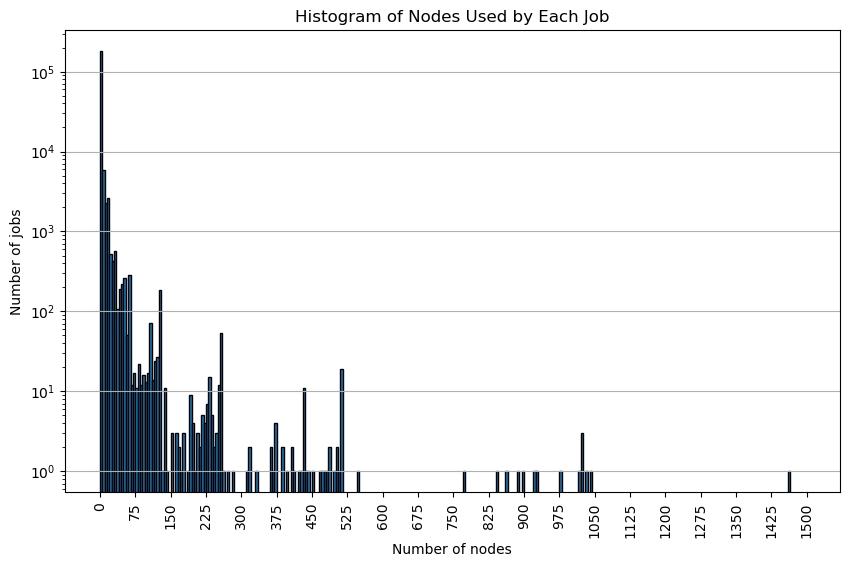

In [42]:
bins = list(range(0, 1500, 5))  # Bins from 0 to 1500, step by 5
xticks = list(range(0, 1575, 75))  # X-ticks from 0 to 1500, step by 75

plt.figure(figsize=(10, 6))
plt.hist(node_counts['unique_nodes'], bins=bins, edgecolor='black')
plt.title('Histogram of Nodes Used by Each Job')
plt.xlabel('Number of nodes')
plt.ylabel('Number of jobs')
plt.xticks(xticks, rotation=90)
plt.yscale('log')
plt.grid(axis='y')
plt.savefig("number_of_nodes_per_job.pdf")
plt.show()

# Number of GPUs used per job

In [44]:
gpus_per_node = jobs_with_g.groupby(['jobid', 'ProducerName'])['gpu_id'].nunique().reset_index()
gpus_per_node = gpus_per_node.rename(columns={'gpu_id': 'gpus_per_node'})

total_gpus_per_job = gpus_per_node.groupby('jobid')['gpus_per_node'].sum().reset_index()
total_gpus_per_job = total_gpus_per_job.rename(columns={'gpus_per_node': 'total_gpus'})

In [55]:
# Group by 'jobid' and 'ProducerName' and apply the function to count unique 'gpu_id'
jobs_with_g_per_node_1 = (jobs_with_g.groupby(['jobid', 'ProducerName'])
                          .apply(lambda x: x[['gpu_id']].drop_duplicates().count(), 
                                 meta={'jobid': 'int64', 'ProducerName': 'object', 'gpu_id': 'int64'})
                          .reset_index())

# Group by 'jobid' again and sum the counts of 'gpu_id'
total_gpus_per_job = jobs_with_g_per_node_1.groupby('jobid')['gpu_id'].sum().reset_index()

# Reset the index twice
total_gpus_per_job = total_gpus_per_job.reset_index().reset_index()

# Number of GPUs per node

In [57]:
gpus_per_node

,jobid,ProducerName,gpus_per_node
npartitions=1,,,
,int64,object,int64
,...,...,...


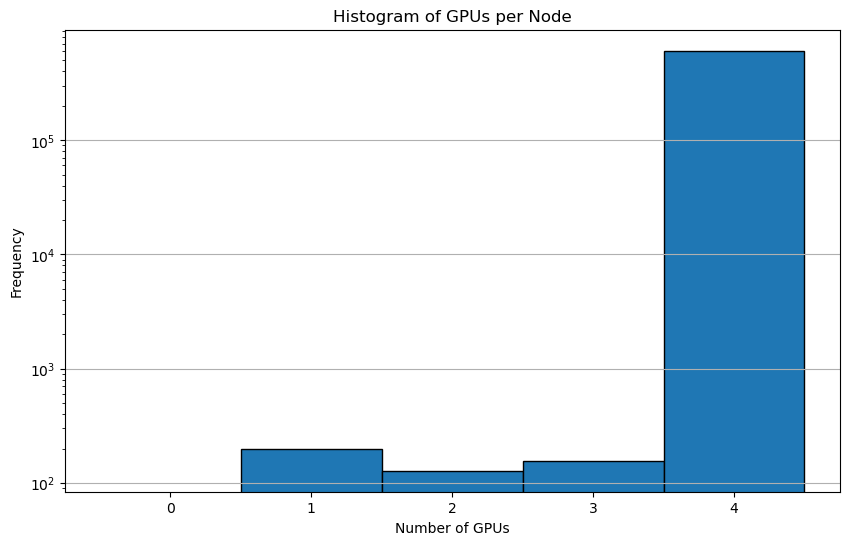

In [47]:
bins = [0, 1, 2, 3, 4, 5] 

plt.figure(figsize=(10, 6))
plt.hist(gpus_per_node['gpus_per_node'], bins=bins, edgecolor='black', align='left')
plt.title('Histogram of GPUs per Node')
plt.xlabel('Number of GPUs')
plt.ylabel('Frequency')
plt.xticks(range(0, 5))
plt.yscale('log')
plt.grid(axis='y')
plt.savefig("number_of_gpus_per_node.pdf")
plt.show()

# Distribution of node hours per job

In [48]:
job_durations = jobs_with_g[['jobid', 'duration']].drop_duplicates()
node_counts_with_duration = node_counts.merge(job_durations, on='jobid', how='left')
node_counts_with_duration['duration_hours'] = node_counts_with_duration['duration'].dt.total_seconds() / 3600
node_counts_with_duration['node_hours'] = node_counts_with_duration['duration_hours'] * node_counts_with_duration['unique_nodes']
node_counts_with_duration

,jobid,unique_nodes,duration,duration_hours,node_hours
npartitions=1,,,,,
,int64,int64,timedelta64[ns],float64,float64
,...,...,...,...,...


In [49]:
node_counts_with_duration["node_hours"].max().compute()

KeyboardInterrupt: 

# Number of jobs submitted each day

In [125]:
job_data = jobs_with_g.groupby('jobid').agg({
    'duration': 'first',
    'start_time': 'first',
    'end_time': 'first'
}).reset_index()

job_data['start_time'] = dd.to_datetime(job_data['start_time'])
job_data['end_time'] = dd.to_datetime(job_data['end_time'])
job_data['submit_date'] = job_data['start_time'].dt.date

job_data = job_data.compute()
daily_job_counts = job_data.groupby('submit_date').size()

print(daily_job_counts)

submit_date
2023-08-04     7166
2023-08-05     4332
2023-08-06     3208
2023-08-07    11863
2023-08-08    10570
              ...  
2023-12-10     2044
2023-12-13     1656
2023-12-14     6165
2023-12-15     4326
2023-12-16     3372
Length: 111, dtype: int64


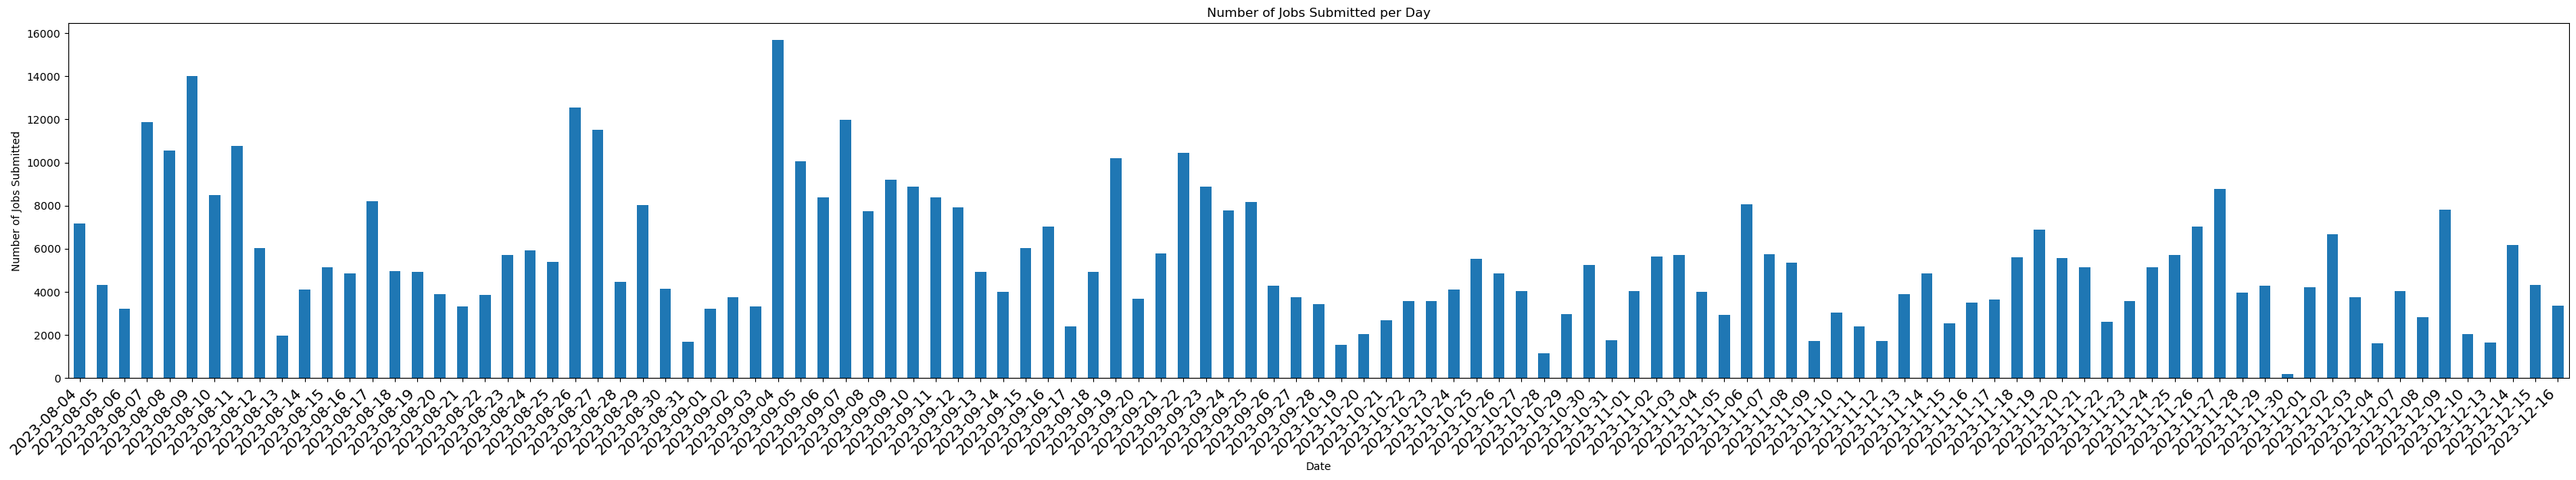

2024-06-04 12:40:14,419 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
2024-06-04 12:40:14,420 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
2024-06-04 12:40:14,421 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
2024-06-04 12:40:14,422 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
2024-06-04 12:40:14,424 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [147]:
plt.figure(figsize=(42, 6))
daily_job_counts.plot(kind='bar')
plt.title('Number of Jobs Submitted per Day')
plt.xlabel('Date')
plt.ylabel('Number of Jobs Submitted')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Optionally adjust the size of the labels
plt.gca().xaxis.set_tick_params(labelsize=14)

# Save the figure
plt.savefig('number_of_jobs_submitted_per_day.pdf')

# Show the plot
plt.show()

# Job submissions by hour of the day and day of the week

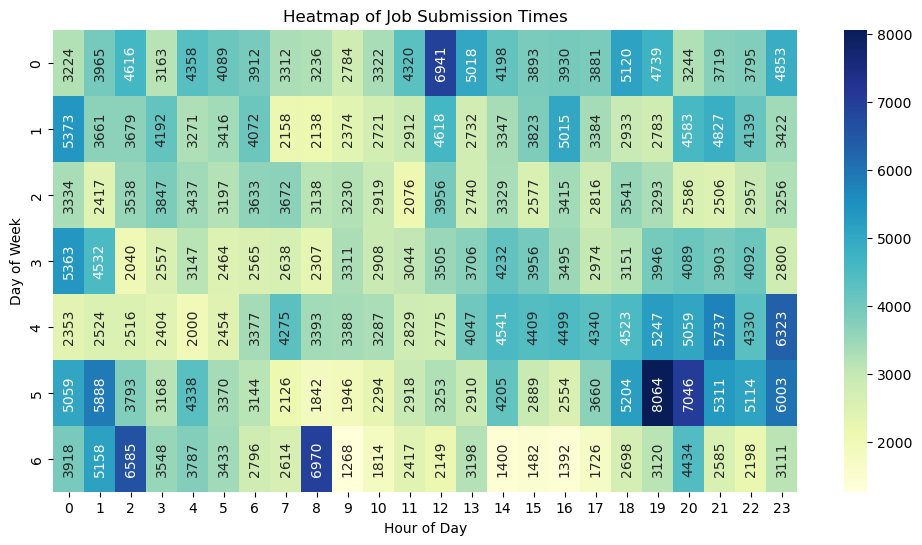

In [127]:
job_data['submit_hour'] = job_data['start_time'].dt.hour
job_data['submit_day'] = job_data['start_time'].dt.dayofweek
job_data['week_number'] = job_data['start_time'].dt.isocalendar().week

submit_heatmap_data = job_data.pivot_table(index='submit_day', columns='submit_hour', aggfunc='size', fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(submit_heatmap_data, cmap="YlGnBu", annot=True, fmt="d", annot_kws={"rotation": 90})
plt.title('Heatmap of Job Submission Times')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

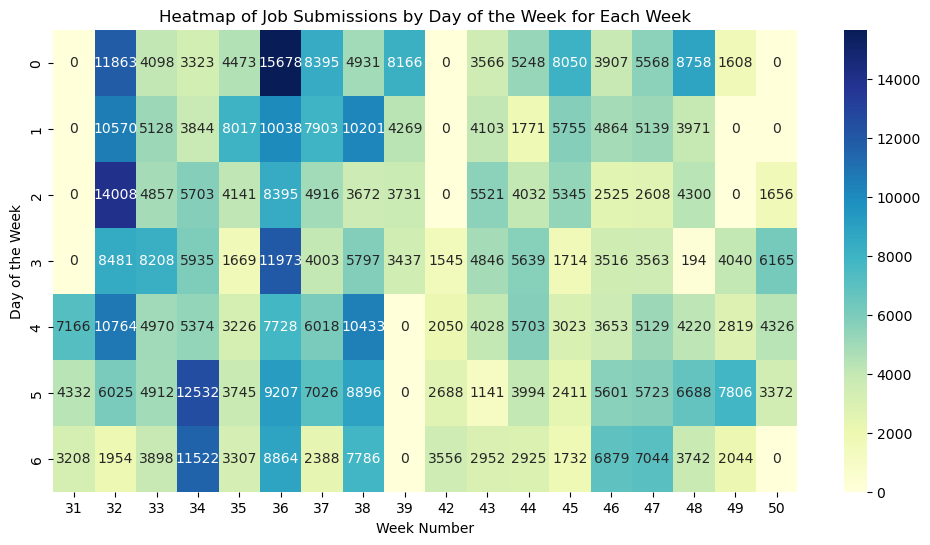

In [149]:
# Plot 1: Heatmap of Days of the Week for Each Week
week_day_counts = job_data.pivot_table(index='submit_day', columns='week_number', aggfunc='size', fill_value=0)
plt.figure(figsize=(12, 6))
sns.heatmap(week_day_counts, cmap="YlGnBu", annot=True, fmt="d")
plt.title('Heatmap of Job Submissions by Day of the Week for Each Week')
plt.xlabel('Week Number')
plt.ylabel('Day of the Week')
# plt.yticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

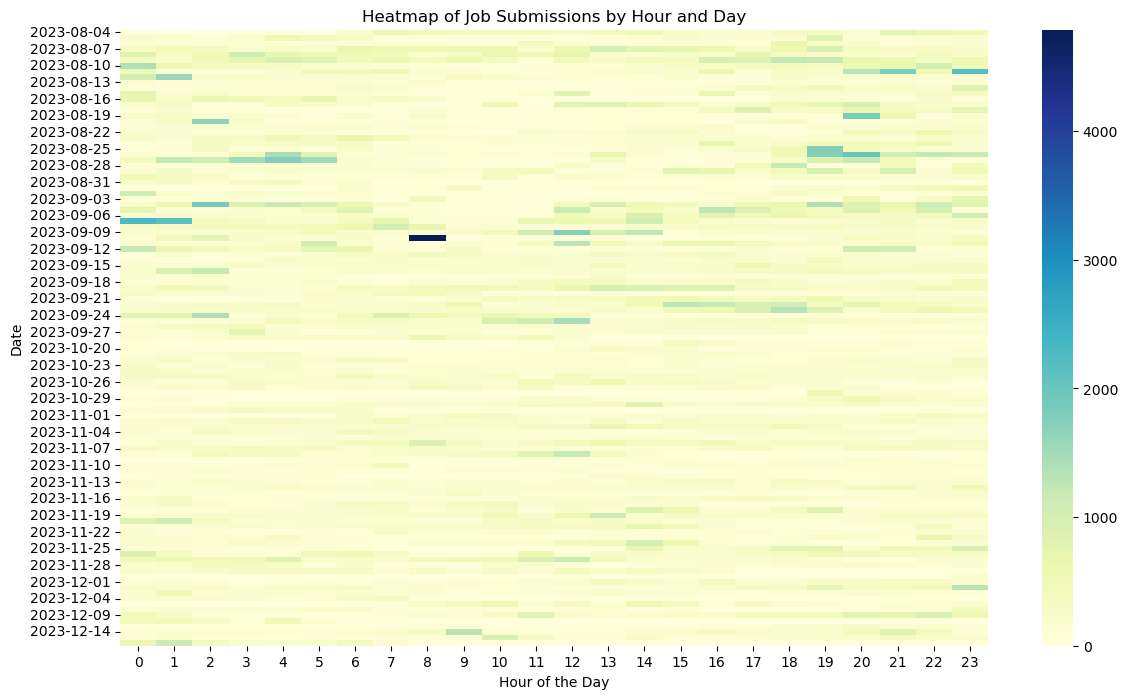

In [166]:
# Create a pivot table with days on the x-axis and hours on the y-axis
job_data['submit_date'] = job_data['start_time'].dt.date
hour_day_counts = job_data.pivot_table(index='submit_date', columns='submit_hour', aggfunc='size', fill_value=0)

plt.figure(figsize=(14, 8))
sns.heatmap(hour_day_counts, cmap="YlGnBu", annot=False, fmt="d")
plt.title('Heatmap of Job Submissions by Hour and Day')
plt.ylabel('Date')
plt.xlabel('Hour of the Day')
# plt.xticks(rotation=45)
# plt.yticks(ticks=range(24), labels=range(24))
plt.show()

In [154]:
hour_day_counts

submit_hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
submit_date,,,,,,,,,,,,,,,,,,,,,
2023-08-04,0,0,0,0,0,0,205,568,494,434,...,528,255,155,127,334,367,173,805,655,490
2023-08-05,228,209,96,188,524,380,286,105,49,43,...,120,253,157,135,149,789,121,85,128,184
2023-08-06,84,50,166,128,77,69,45,85,50,54,...,36,102,85,44,640,294,201,84,59,147
2023-08-07,352,494,360,174,265,210,660,614,586,581,...,784,697,592,276,610,920,385,337,340,222
2023-08-08,812,344,547,1070,700,585,501,427,218,300,...,178,297,203,729,356,193,223,183,399,249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-10,479,501,285,97,451,127,58,46,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-12-13,0,0,0,0,0,0,0,32,91,34,...,40,51,66,64,172,198,307,150,204,93
2023-12-14,108,158,146,141,113,110,146,202,336,1305,...,144,197,351,227,163,206,436,818,398,60


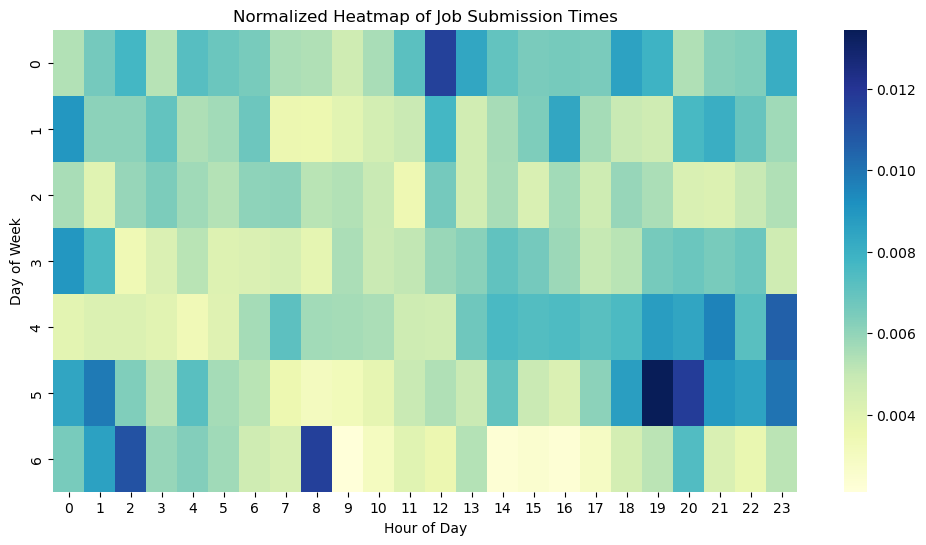

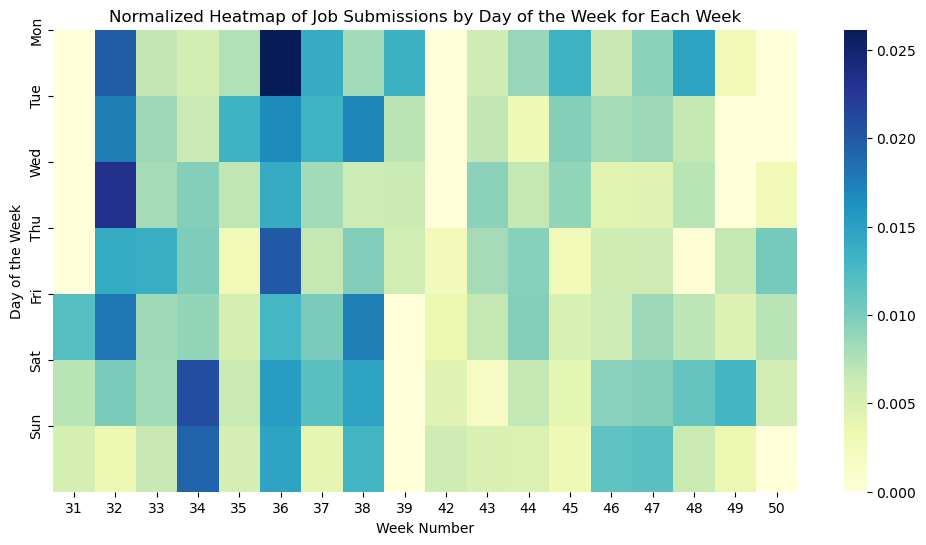

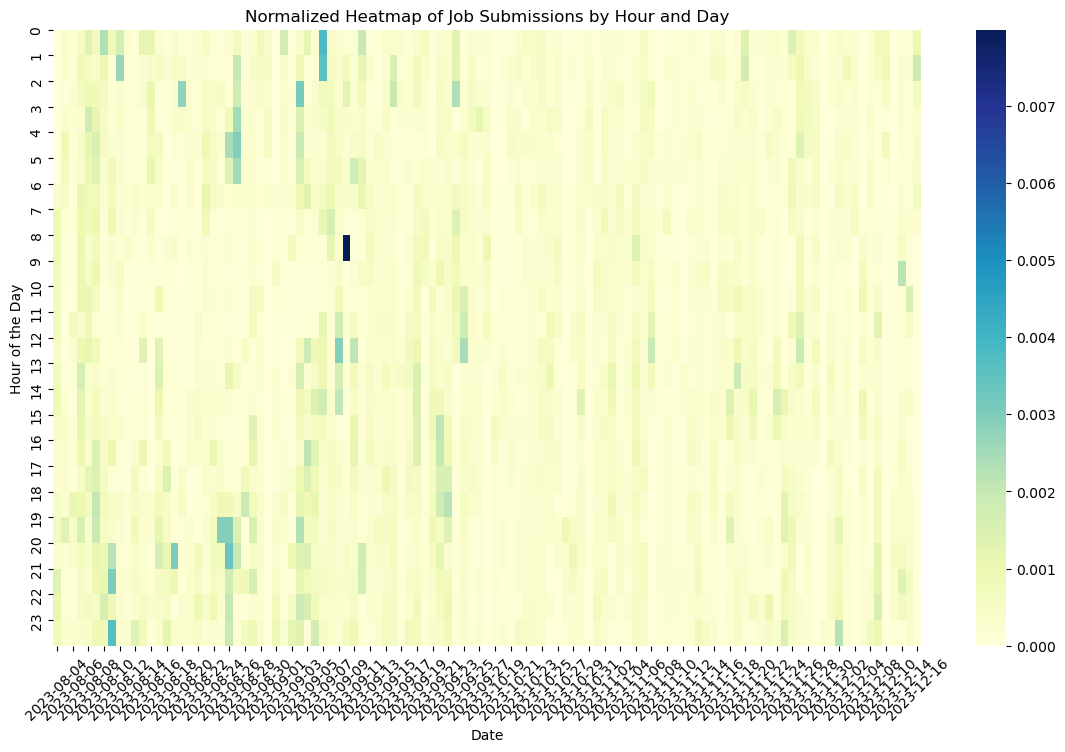

In [131]:
# Create additional time-based columns
job_data['submit_hour'] = job_data['start_time'].dt.hour
job_data['submit_day'] = job_data['start_time'].dt.dayofweek
job_data['week_number'] = job_data['start_time'].dt.isocalendar().week
job_data['submit_date'] = job_data['start_time'].dt.date

# Heatmap of Job Submission Times by Hour and Day
submit_heatmap_data = job_data.pivot_table(index='submit_day', columns='submit_hour', aggfunc='size', fill_value=0)
submit_heatmap_data_normalized = submit_heatmap_data / submit_heatmap_data.sum().sum()

plt.figure(figsize=(12, 6))
sns.heatmap(submit_heatmap_data_normalized, cmap="YlGnBu", annot=False, fmt=".2f")
plt.title('Normalized Heatmap of Job Submission Times')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

# Heatmap of Job Submissions by Day of the Week for Each Week
week_day_counts = job_data.pivot_table(index='submit_day', columns='week_number', aggfunc='size', fill_value=0)
week_day_counts_normalized = week_day_counts / week_day_counts.sum().sum()

plt.figure(figsize=(12, 6))
sns.heatmap(week_day_counts_normalized, cmap="YlGnBu", annot=False, fmt=".2f")
plt.title('Normalized Heatmap of Job Submissions by Day of the Week for Each Week')
plt.xlabel('Week Number')
plt.ylabel('Day of the Week')
plt.yticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

# Heatmap of Job Submissions by Hour and Day
hour_day_counts = job_data.pivot_table(index='submit_hour', columns='submit_date', aggfunc='size', fill_value=0)
hour_day_counts_normalized = hour_day_counts / hour_day_counts.sum().sum()

plt.figure(figsize=(14, 8))
sns.heatmap(hour_day_counts_normalized, cmap="YlGnBu", annot=False, fmt=".2f")
plt.title('Normalized Heatmap of Job Submissions by Hour and Day')
plt.xlabel('Date')
plt.ylabel('Hour of the Day')
plt.xticks(rotation=45)
plt.yticks(ticks=range(24), labels=range(24))
plt.show()

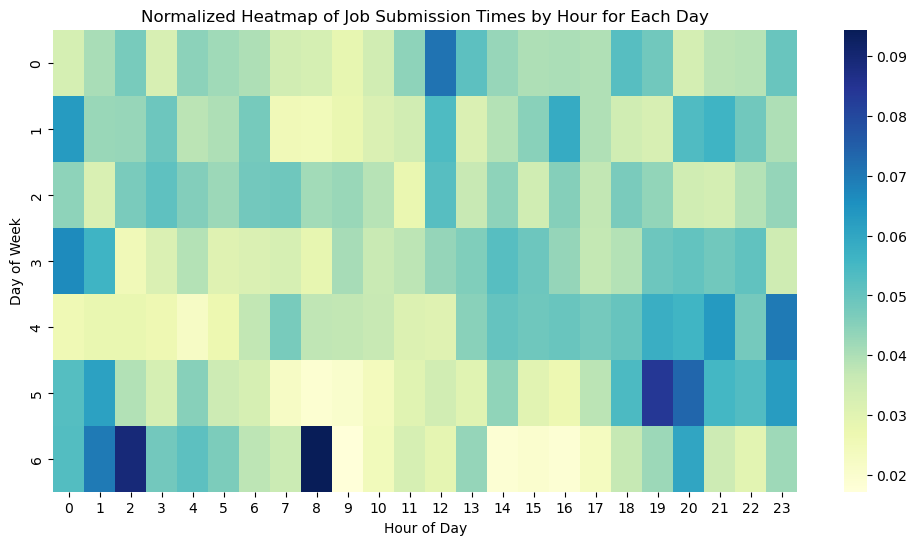

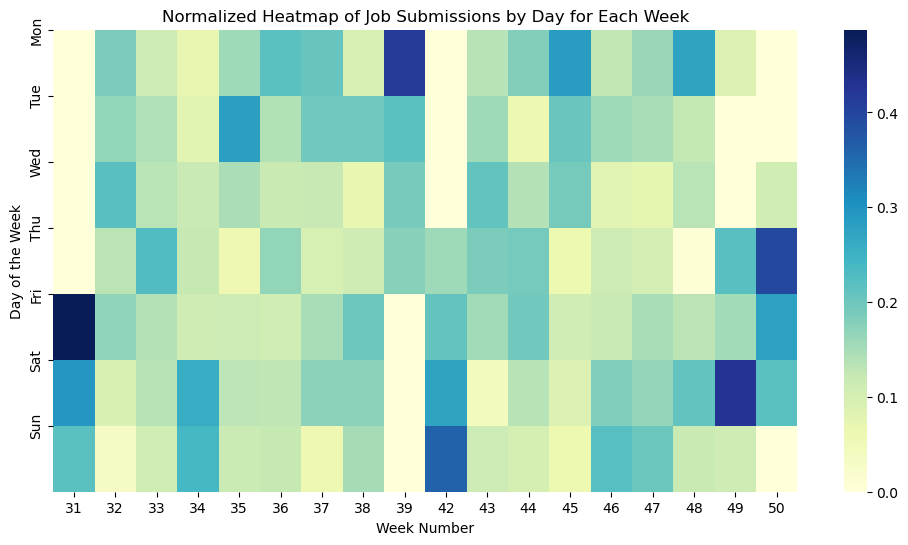

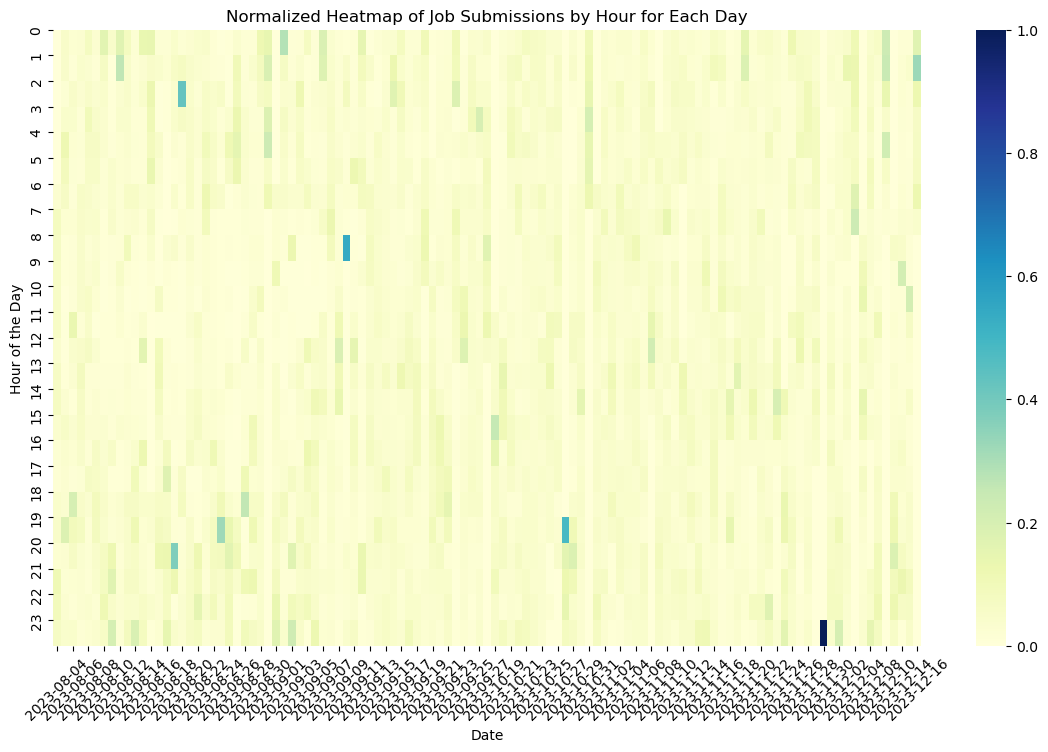

In [138]:
job_data['submit_hour'] = job_data['start_time'].dt.hour
job_data['submit_day'] = job_data['start_time'].dt.dayofweek
job_data['week_number'] = job_data['start_time'].dt.isocalendar().week
job_data['submit_date'] = job_data['start_time'].dt.date

# Heatmap of Job Submission Times by Hour and Day
submit_heatmap_data = job_data.pivot_table(index='submit_day', columns='submit_hour', aggfunc='size', fill_value=0)
submit_heatmap_data_normalized = submit_heatmap_data.div(submit_heatmap_data.sum(axis=1), axis=0)

plt.figure(figsize=(12, 6))
sns.heatmap(submit_heatmap_data_normalized, cmap="YlGnBu", annot=False, fmt=".2f")
plt.title('Normalized Heatmap of Job Submission Times by Hour for Each Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

week_day_counts = job_data.pivot_table(index='submit_day', columns='week_number', aggfunc='size', fill_value=0)
week_day_counts_normalized = week_day_counts.div(week_day_counts.sum(axis=0), axis=1)

plt.figure(figsize=(12, 6))
sns.heatmap(week_day_counts_normalized, cmap="YlGnBu", annot=False, fmt=".2f")
plt.title('Normalized Heatmap of Job Submissions by Day for Each Week')
plt.xlabel('Week Number')
plt.ylabel('Day of the Week')
plt.yticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

hour_day_counts = job_data.pivot_table(index='submit_hour', columns='submit_date', aggfunc='size', fill_value=0)
hour_day_counts_normalized = hour_day_counts.div(hour_day_counts.sum(axis=0), axis=1)

plt.figure(figsize=(14, 8))
sns.heatmap(hour_day_counts_normalized, cmap="YlGnBu", annot=False, fmt=".2f")
plt.title('Normalized Heatmap of Job Submissions by Hour for Each Day')
plt.xlabel('Date')
plt.ylabel('Hour of the Day')
plt.xticks(rotation=45)
plt.yticks(ticks=range(24), labels=range(24))
plt.show()

# Number of jobs submitted per Account

# Node hours used per Account

In [167]:
job_data = jobs_with_g.groupby('jobid').agg({
    'Account': 'first',
    'SubmitLine': 'first',
    'start_time': 'first',
    'end_time': 'first',
    'nnodes': 'first'
}).reset_index()

In [12]:
job_data['job_duration_hours'] = (job_data['end_time'] - job_data['start_time']).dt.total_seconds() / 3600
job_data['node_hours'] = job_data['nnodes'] * job_data['job_duration_hours']
average_node_hours_per_account = job_data.groupby('Account')['node_hours'].mean()
average_node_hours_per_account

Dask Series Structure:
npartitions=1
    float64
        ...
Name: node_hours, dtype: float64
Dask Name: truediv, 71 graph layers

In [20]:
print(average_node_hours_per_account.max().compute())

376.23160493827163


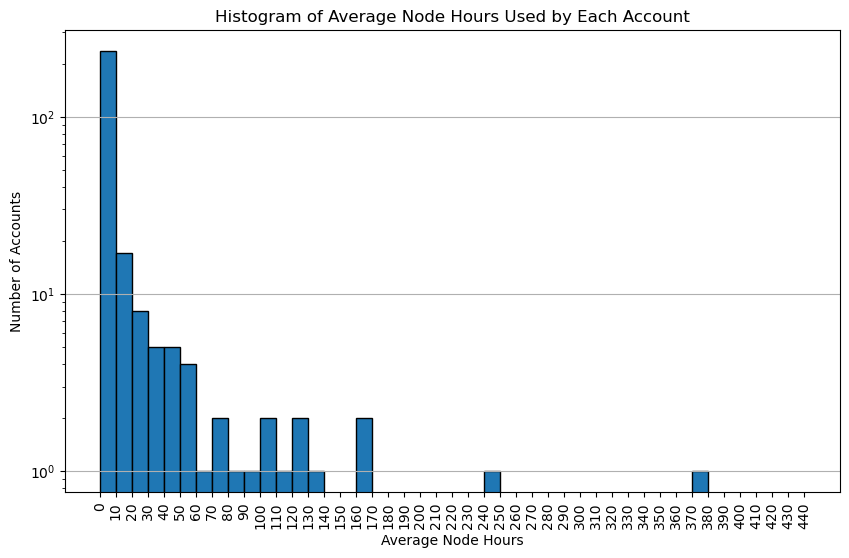

In [21]:
bins = list(range(0, 450, 10))

plt.figure(figsize=(10, 6))
plt.hist(average_node_hours_per_account, bins=bins, edgecolor='black')
plt.title('Histogram of Average Node Hours Used by Each Account')
plt.xlabel('Average Node Hours')
plt.ylabel('Number of Accounts')
plt.xticks(bins)
plt.yscale('log')  
plt.grid(axis='y')
plt.xticks(rotation=90)
plt.show()

In [15]:
average_node_hours_per_account_10 = average_node_hours_per_account[average_node_hours_per_account <= 10]
average_node_hours_per_account_10

Dask Series Structure:
npartitions=1
    float64
        ...
Name: node_hours, dtype: float64
Dask Name: index, 73 graph layers

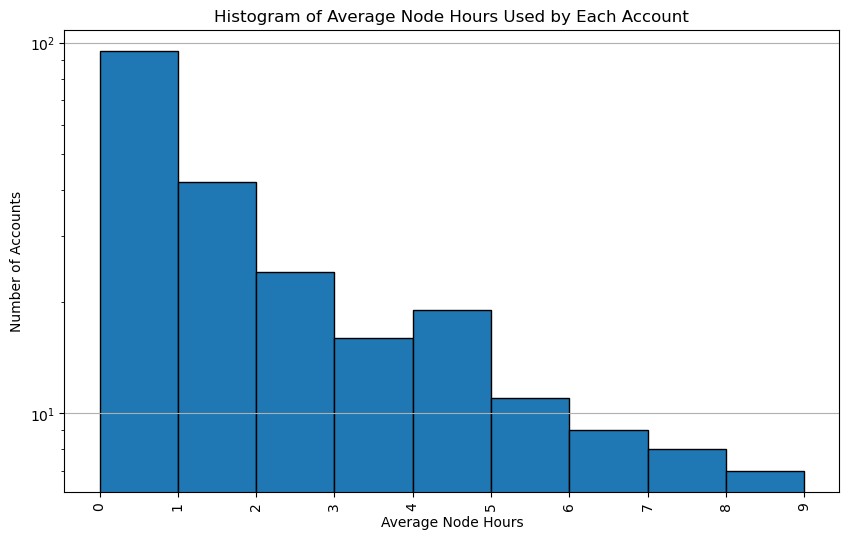

In [16]:
bins = list(range(0, 10, 1))

plt.figure(figsize=(10, 6))
plt.hist(average_node_hours_per_account_10, bins=bins, edgecolor='black')
plt.title('Histogram of Average Node Hours Used by Each Account')
plt.xlabel('Average Node Hours')
plt.ylabel('Number of Accounts')
plt.xticks(bins)
plt.yscale('log')  
plt.grid(axis='y')
plt.xticks(rotation=90)
plt.show()

# Number of deep learning applications

In [198]:
deep_learning_keywords = [
    'epoch', 'batch', 'training', 'neural', 'model', 'cnn', 'rnn', 'lstm', 
    'transformer', 'bert', 'tensorflow', 'pytorch', 'keras', 'deep', 'learning', 
    'ai', 'machine', 'ml'
]

job_data = jobs_with_g.groupby('jobid').agg({
    'SubmitLine': 'first',
    'JobName': 'first',
}).reset_index()

# Function to check for deep learning keywords
def is_deep_learning_application(row):
    text = f"{row['SubmitLine']}".lower()
    return any(keyword in text for keyword in deep_learning_keywords)

# Apply the function to each partition
job_data['is_deep_learning'] = job_data.map_partitions(
    lambda df: df.apply(is_deep_learning_application, axis=1),
    meta=('is_deep_learning', 'bool')
)

# Compute the results
deep_learning_job_count = job_data['is_deep_learning'].sum().compute()
total_jobs = len(job_data)

print("The total number of jobs: ", total_jobs)
print("Deep learning jobs: ", deep_learning_job_count)

The total number of jobs:  599870
Deep learning jobs:  74279


In [ ]:
print(node_counts[node_counts["unique_nodes"] > 1].nunique().compute())

In [227]:
print(node_counts[node_counts["unique_nodes"] == 1].nunique().compute())

jobid           448323
unique_nodes         1
dtype: int64
